# Diffusion Model
**Dhwanil Panchani**<br>
**002840688**

### Project requirements:
### Use a latent diffusion model to generate images from text. Utilize pre-trained VAE and U-Net models from OpenAI, but fine-tune the CLIP model to build the diffusion model. Select a suitable image dataset with captions to fine-tune the CLIP model.

In [1]:
# Importing Libraries

from tqdm.auto import tqdm
from torch import autocast
import torch
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
import numpy as np

**The `CLIPFineTuner` class is designed to fine-tune OpenAI's CLIP model by aligning the dimensions of text and image features using projection layers. This allows for effective computation of similarities between text and image inputs.**

In [2]:
import torch.nn as nn

class CLIPFineTuner(nn.Module):
    def __init__(self, text_encoder, vision_encoder, projection_dim=512):
        super().__init__()
        self.text_encoder = text_encoder
        self.vision_encoder = vision_encoder
        
        # Add projection layers to align dimensions
        self.text_projection = nn.Linear(768, projection_dim)  # Project text features
        self.image_projection = nn.Linear(1024, projection_dim)  # Project image features
        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, images, input_ids, attention_mask):
        # Extract features
        image_features = self.vision_encoder(images).last_hidden_state[:, 0, :]
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Project features into the same dimension
        image_features = self.image_projection(image_features)
        text_features = self.text_projection(text_features)
        
        # Normalize projected features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text
    
def get_text_encoder(te):
    vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")    
    fine_tuned_model = CLIPFineTuner(text_encoder, vision_encoder) 
    if te == 1:
        fine_tuned_model.load_state_dict(torch.load("./fine_tuned_clip.pth", weights_only=False))
        fine_tuned_model.eval()
    elif te == 2:
        fine_tuned_model.load_state_dict(torch.load("./clip_fine_tuned_cifar10.pth", weights_only=False))
        fine_tuned_model.eval()
    else:
        return None
    return fine_tuned_model.text_encoder

**The below code initializes key components of the Stable Diffusion pipeline, which includes an autoencoder, a tokenizer, a text encoder, a UNet model, and a scheduler. These components work together to convert textual descriptions into corresponding images.**

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

## Generate Image for Text

In [4]:
def generte_image_from_text(prompt, vae, tokenizer, text_encoder, unet, height = 512, width = 512, num_inference_steps = 50, te=0,
                           guidance_scale = 7.5, seed = 32):
    
    vae = vae.to(torch_device)
    text_encoder = text_encoder.to(torch_device)
    unet = unet.to(torch_device)
    
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    
    if get_text_encoder(te):
        text_encoder = get_text_encoder(te).to(torch_device)
    else:
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
           
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    latents = torch.randn(
      (batch_size, unet.config.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)

    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
        
    image = (image / 2 + 0.5).clip(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

Enter Prompt:  An image of an automobile


  0%|          | 0/50 [00:00<?, ?it/s]

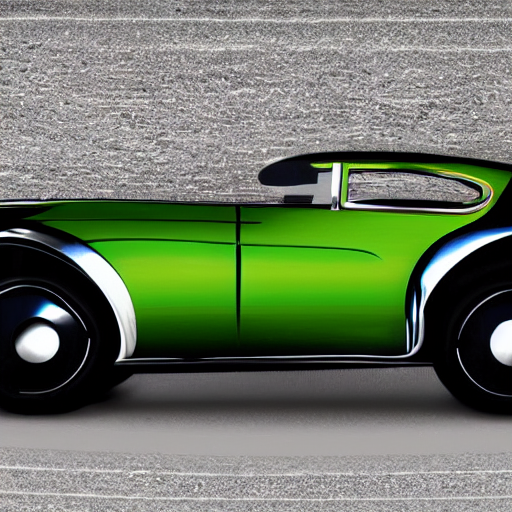

In [5]:
from random import randint
seed = randint(0, 1000000)
# seed = 42
prompt = input("Enter Prompt: ") 
generte_image_from_text(prompt=prompt, seed=seed, vae=vae, tokenizer=tokenizer, text_encoder=text_encoder, unet=unet, te=2)